In [2]:
import glob
import h5py
import numpy as np
from quant_met import mean_field, utils, plotting
import matplotlib.pyplot as plt
from pathlib import Path
import pandas as pd

In [3]:
lattice_constant = np.sqrt(3)

all_K_points = 4 * np.pi / (3 * lattice_constant) * np.array([
    (np.sin(i * np.pi / 6), np.cos(i * np.pi / 6)) for i in [1, 3, 5, 7, 9, 11]]
)

BZ_grid = utils.generate_uniform_grid(5, 5, all_K_points[1], all_K_points[5], origin=np.array([0, 0]))

Gamma = np.array([0, 0])
M = np.pi / lattice_constant * np.array([1, 1 / np.sqrt(3)])
K = 4 * np.pi / (3 * lattice_constant) * np.array([1, 0])

points = [(M, 'M'), (Gamma, r'\Gamma'), (all_K_points[1], 'K')]

band_path, band_path_plot, ticks, labels = plotting.generate_bz_path(points, number_of_points=1000)

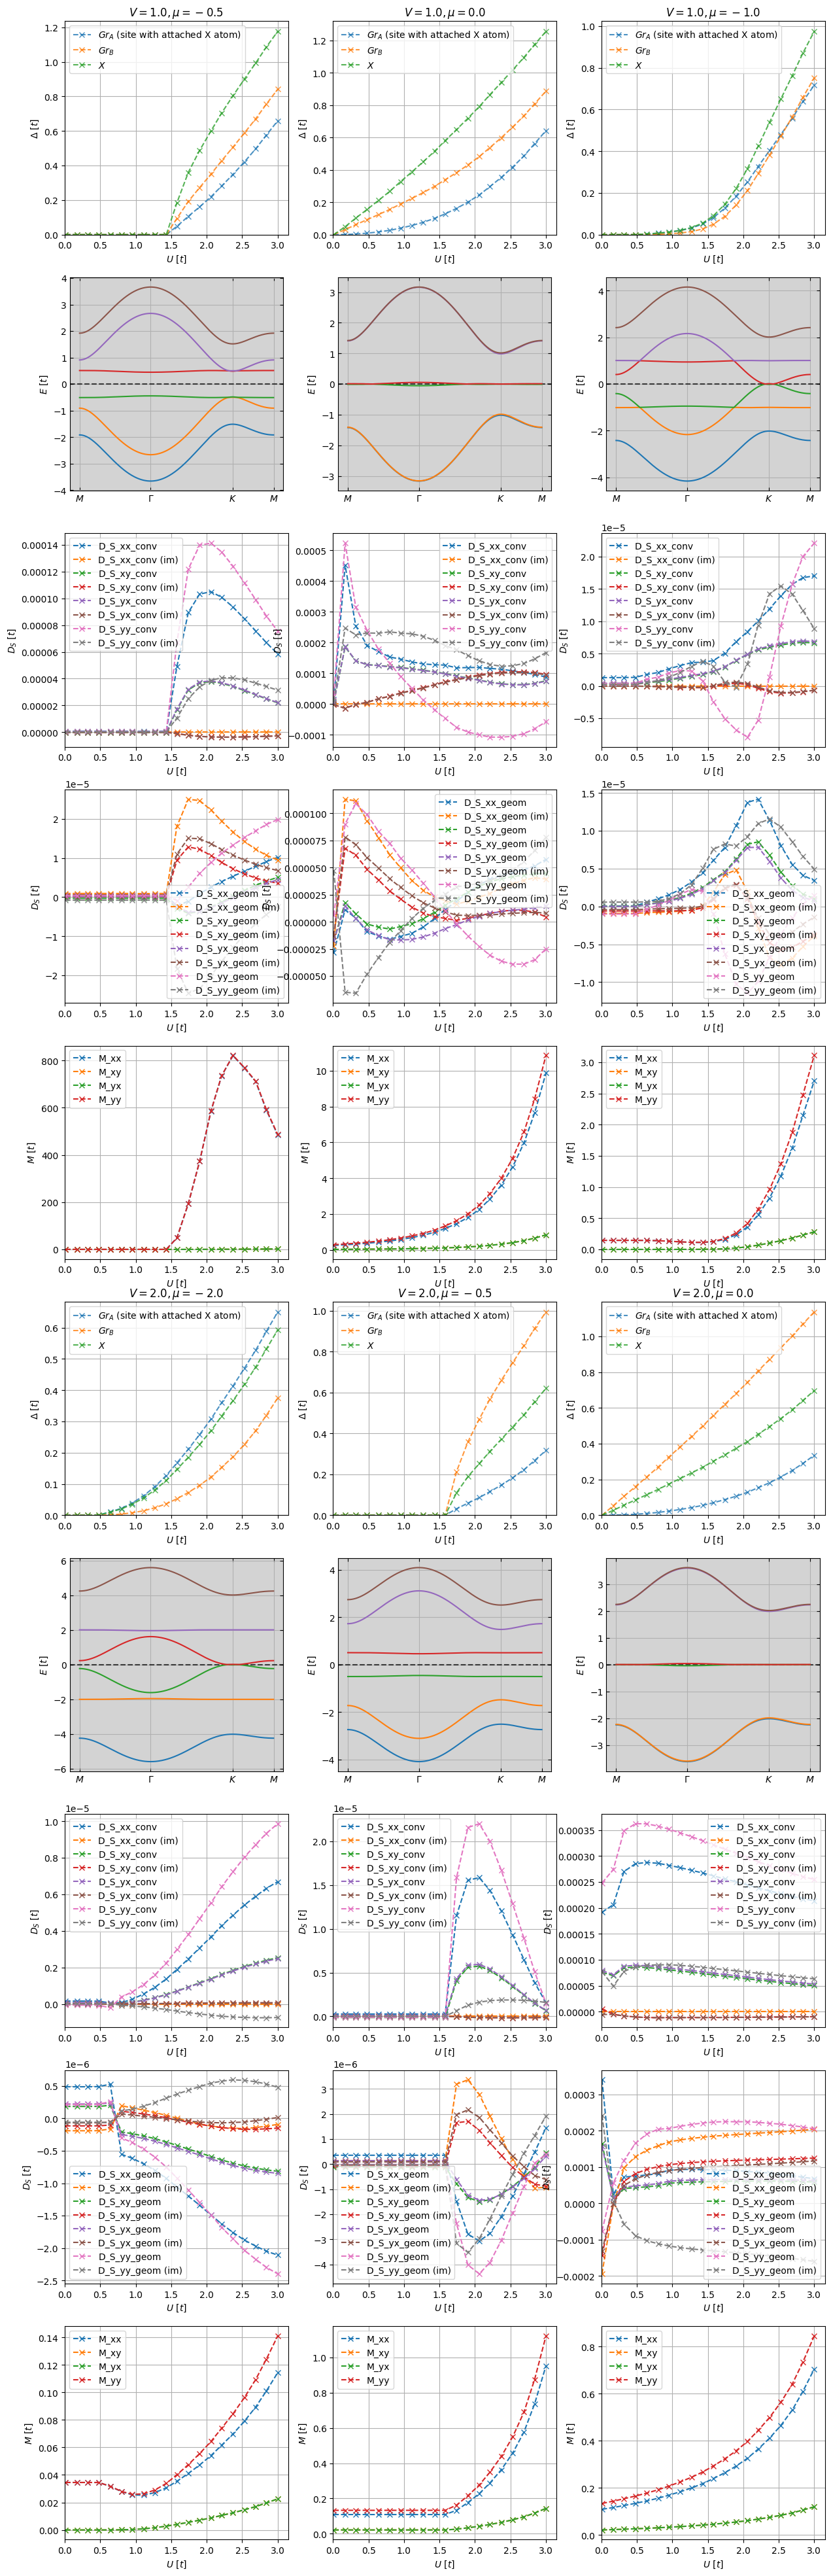

In [11]:
V_dirs = glob.glob("../minimise_results/*")

mu_dirs_test = glob.glob(f'{V_dirs[0]}/*')

number_of_rows = 5

fig, axs = plt.subplots(nrows=number_of_rows*len(V_dirs), ncols=len(mu_dirs_test), figsize=(len(mu_dirs_test)*5, number_of_rows*5*len(V_dirs)))

for V_index, V_dir in enumerate(V_dirs):
    V = float(V_dir.split("/")[-1].split("_")[-1])
    mu_dirs = glob.glob(f'{V_dir}/*')
    
    for mu_index, mu_dir in enumerate(mu_dirs):
        mu = float(mu_dir.split("/")[-1].split("_")[-1])
        
        """Plot gap size."""
        
        if len(mu_dirs) == 1:
            ax = axs[number_of_rows*V_index]
        else:
            ax = axs[number_of_rows*V_index, mu_index]
        
        U_files = glob.glob(f'{mu_dir}/U_*.hdf5')
        
        U_list = np.sort(np.array([float(U_file.split('/')[-1].split("_")[-1].removesuffix('.hdf5')) for U_file in U_files]))
        
        delta_0 = np.zeros(shape=U_list.shape, dtype=complex)
        delta_1 = np.zeros(shape=U_list.shape, dtype=complex)
        delta_2 = np.zeros(shape=U_list.shape, dtype=complex)
        
        D_S = pd.DataFrame(index=range(len(U_list)), dtype=complex, columns=[
            'D_S_xx_conv',
            'D_S_xy_conv',
            'D_S_yx_conv',
            'D_S_yy_conv',
            'D_S_xx_geom',
            'D_S_xy_geom',
            'D_S_yx_geom',
            'D_S_yy_geom',
        ])
        
        quantum_metric = pd.DataFrame(index=range(len(U_list)), dtype=float, columns=[
            'M_xx',
            'M_xy',
            'M_yx',
            'M_yy',
        ])
        
        for U_index, U in enumerate(U_list):
            egx_h = mean_field.EGXHamiltonian.from_file(Path(f'{mu_dir}/U_{U:.2f}.hdf5'))
            
            # Get gaps from Hamiltonian (and correct global phase)
            #delta_global_phase = np.angle(egx_h.delta_orbital_basis[0])
            #delta_0[U_index] = np.exp(-1j * delta_global_phase) * egx_h.delta_orbital_basis[0]
            #delta_1[U_index] = np.exp(-1j * delta_global_phase) * egx_h.delta_orbital_basis[1]
            #delta_2[U_index] = np.exp(-1j * delta_global_phase) * egx_h.delta_orbital_basis[2]
            delta_0[U_index] = egx_h.delta_orbital_basis[0]
            delta_1[U_index] = egx_h.delta_orbital_basis[1]
            delta_2[U_index] = egx_h.delta_orbital_basis[2]
            
            # Calculate superfluid weight (and correct global phase)
            with h5py.File(f'{mu_dir}/U_{U:.2f}.hdf5', 'r') as f:
                D_S.iloc[U_index] = [
                    f.attrs[key] for key in [
                        'D_S_xx_conv',
                        'D_S_xy_conv',
                        'D_S_yx_conv',
                        'D_S_yy_conv',
                        'D_S_xx_geom',
                        'D_S_xy_geom',
                        'D_S_yx_geom',
                        'D_S_yy_geom',
                    ]
                ]
                
            # Calculate quantum metric for the BdG state
            quantum_metric_U = mean_field.quantum_metric_bdg(h=egx_h, k_grid=BZ_grid, band=2)
            
            quantum_metric.iloc[U_index] = (
                quantum_metric_U[0, 0],
                quantum_metric_U[0, 1],
                quantum_metric_U[1, 0],
                quantum_metric_U[1, 1],
            )
            
        """All the plotting.""" 
        
        """Plot sizes."""
        
        ax.plot(U_list, np.real(delta_0), 'x--', label='$Gr_A$ (site with attached X atom)', alpha=0.8)
        ax.plot(U_list, np.real(delta_1), 'x--', label='$Gr_B$', alpha=0.8)
        ax.plot(U_list, np.real(delta_2), 'x--', label='$X$', alpha=0.8)
        """
        ax.plot(U_list, np.imag(delta_0), 'x--', label='$Gr_A$ (site with attached X atom) (im)', alpha=0.8)
        ax.plot(U_list, np.imag(delta_1), 'x--', label='$Gr_B (im)$', alpha=0.8)
        ax.plot(U_list, np.imag(delta_2), 'x--', label='$X$ (im)', alpha=0.8)
        """
        
        ax.set_ylim(bottom=0)
        ax.set_xlim(left=0)
        ax.grid(True)
        ax.set_xlabel(r'$U\ [t]$')
        ax.set_ylabel(r'$\Delta\ [t]$')
        ax.set_title(f'$V = {V}, \\mu = {mu}$')
        ax.legend()
        
        """Plot BdG energies."""
        
        if len(mu_dirs) == 1:
            ax = axs[number_of_rows*V_index+1]
        else:
            ax = axs[number_of_rows*V_index+1, mu_index]

        egx_h = mean_field.EGXHamiltonian(
            hopping_gr=1,
            hopping_x=0.01,
            lattice_constant=lattice_constant,
            hopping_x_gr_a=V,
            mu=mu,
            coloumb_gr=0,
            coloumb_x=0,
            delta=np.zeros(shape=3, dtype=complex)
        )
        
        bdg_energies, _ = egx_h.diagonalize_bdg(k=band_path)

        bdg_energies = bdg_energies.T

        plotting.plot_bandstructure(bands=bdg_energies, k_point_list=band_path_plot, ticks=ticks, labels=labels, fig_in=fig, ax_in=ax)
        
        """Plot superfluid weight."""
        
        if len(mu_dirs) == 1:
            ax = axs[number_of_rows*V_index+2]
        else:
            ax = axs[number_of_rows*V_index+2, mu_index]
            
        ax.plot(U_list, np.real(D_S.loc[:, 'D_S_xx_conv']), 'x--', label='D_S_xx_conv')
        ax.plot(U_list, np.imag(D_S.loc[:, 'D_S_xx_conv']), 'x--', label='D_S_xx_conv (im)')
        
        ax.plot(U_list, np.real(D_S.loc[:, 'D_S_xy_conv']), 'x--', label='D_S_xy_conv')
        ax.plot(U_list, np.imag(D_S.loc[:, 'D_S_xy_conv']), 'x--', label='D_S_xy_conv (im)')
        
        ax.plot(U_list, np.real(D_S.loc[:, 'D_S_yx_conv']), 'x--', label='D_S_yx_conv')
        ax.plot(U_list, np.imag(D_S.loc[:, 'D_S_yx_conv']), 'x--', label='D_S_yx_conv (im)')
        
        ax.plot(U_list, np.real(D_S.loc[:, 'D_S_yy_conv']), 'x--', label='D_S_yy_conv')
        ax.plot(U_list, np.imag(D_S.loc[:, 'D_S_yy_conv']), 'x--', label='D_S_yy_conv (im)')
        
        ax.legend()
        ax.set_xlim(left=0)
        ax.grid(True)
        ax.set_xlabel(r'$U\ [t]$')
        ax.set_ylabel(r'$D_S\ [t]$')

        """Plot geometric contribution to superfluid weight."""

        if len(mu_dirs) == 1:
            ax = axs[number_of_rows*V_index+3]
        else:
            ax = axs[number_of_rows*V_index+3, mu_index]

        ax.plot(U_list, np.real(D_S.loc[:, 'D_S_xx_geom']), 'x--', label='D_S_xx_geom')
        ax.plot(U_list, np.imag(D_S.loc[:, 'D_S_xx_geom']), 'x--', label='D_S_xx_geom (im)')

        ax.plot(U_list, np.real(D_S.loc[:, 'D_S_xy_geom']), 'x--', label='D_S_xy_geom')
        ax.plot(U_list, np.imag(D_S.loc[:, 'D_S_xy_geom']), 'x--', label='D_S_xy_geom (im)')

        ax.plot(U_list, np.real(D_S.loc[:, 'D_S_yx_geom']), 'x--', label='D_S_yx_geom')
        ax.plot(U_list, np.imag(D_S.loc[:, 'D_S_yx_geom']), 'x--', label='D_S_yx_geom (im)')

        ax.plot(U_list, np.real(D_S.loc[:, 'D_S_yy_geom']), 'x--', label='D_S_yy_geom')
        ax.plot(U_list, np.imag(D_S.loc[:, 'D_S_yy_geom']), 'x--', label='D_S_yy_geom (im)')

        ax.legend()
        ax.set_xlim(left=0)
        ax.grid(True)
        ax.set_xlabel(r'$U\ [t]$')
        ax.set_ylabel(r'$D_S\ [t]$')
        
        """Plot BdG quantum metric."""

        if len(mu_dirs) == 1:
            ax = axs[number_of_rows*V_index+4]
        else:
            ax = axs[number_of_rows*V_index+4, mu_index]
            
        ax.plot(U_list, quantum_metric.loc[:, 'M_xx'], 'x--', label='M_xx')
        ax.plot(U_list, quantum_metric.loc[:, 'M_xy'], 'x--', label='M_xy')
        ax.plot(U_list, quantum_metric.loc[:, 'M_yx'], 'x--', label='M_yx')
        ax.plot(U_list, quantum_metric.loc[:, 'M_yy'], 'x--', label='M_yy')
        
        ax.legend()
        ax.set_xlim(left=0)
        ax.grid(True)
        ax.set_xlabel(r'$U\ [t]$')
        ax.set_ylabel(r'$M\ [t]$')